# Floquet simulations in QuTiP

This is an example notebook demonstrating how to use Floquet theory framework for time evolution of quantum system under QuTiP.

Code is available at https://gitlab.inria.fr/lverney/qutip_floquet_example/.

Author: Lucas Verney
License: MIT

## Unitary evolution

In [1]:
%matplotlib notebook
# Imports
import matplotlib.pyplot as plt
import numpy as np

from qutip import *

In [2]:
# Parameters
omega_0 = 1.0 * 2 * np.pi
Omega = 0.1 * 2 * np.pi
omega_d = 1.5 * 2 * np.pi
T = 2 * np.pi / omega_d

In [3]:
# Hamiltonian
H0 = omega_0 / 2.0 * sigmaz()  # Time-independent part
H1 = Omega * sigmax()  # Time-dependent part
H2 = Omega * sigmay()  # Time-dependent part

# Time-dependent hamiltonian specification
H = [H0, [H1, 'cos(w_d * t)'], [H2, 'sin(w_d * t)']]
args = {'w_d': omega_d}

### Floquet modes at $t=0$

In [4]:
# If we want Floquet modes at t=0 explicitly,
f_modes_0, f_energies = floquet_modes(H, T, args)

In [5]:
f_energies

array([ 3.02058947, -3.02058947])

<IPython.core.display.Javascript object>


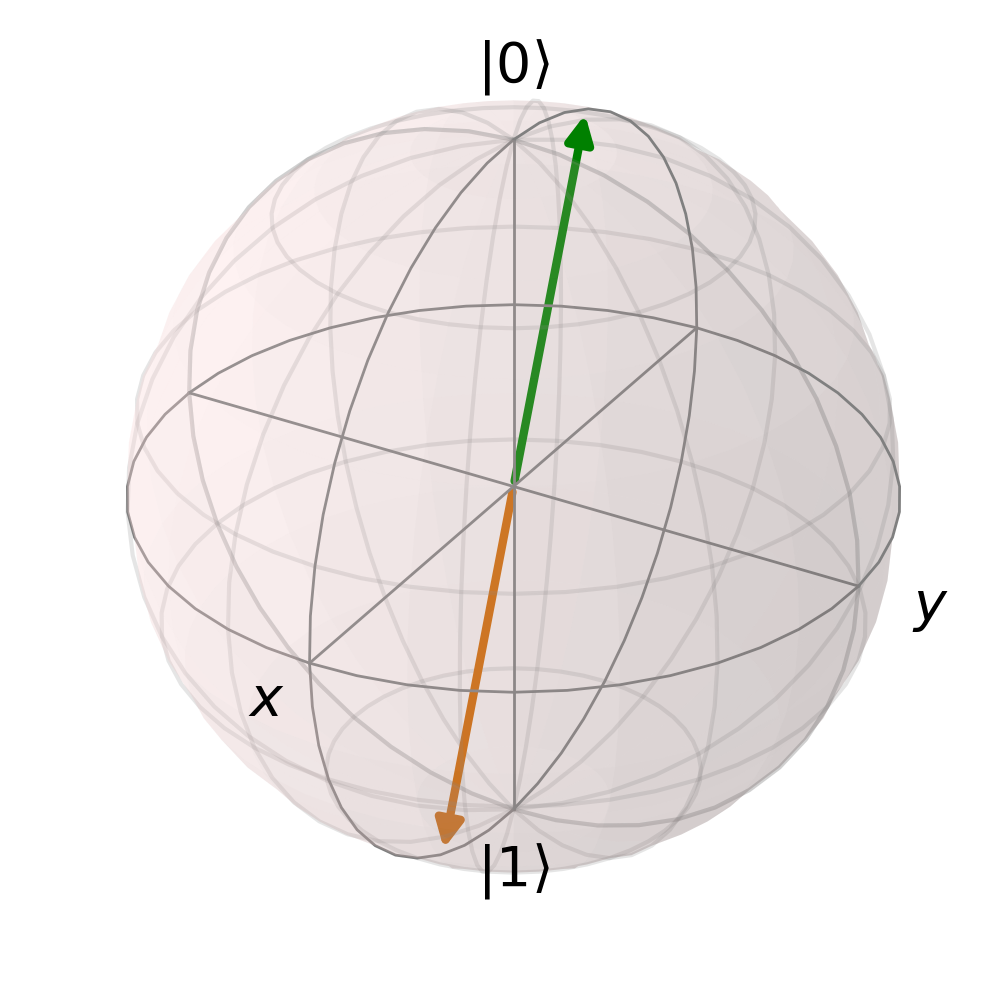

In [6]:
b = Bloch()
b.add_states(f_modes_0)
b.show()

### Floquet modes at any $t$

In [7]:
t = T / 5.0
f_modes_t = floquet_modes_t(f_modes_0, f_energies, t, H, T, args)

<IPython.core.display.Javascript object>


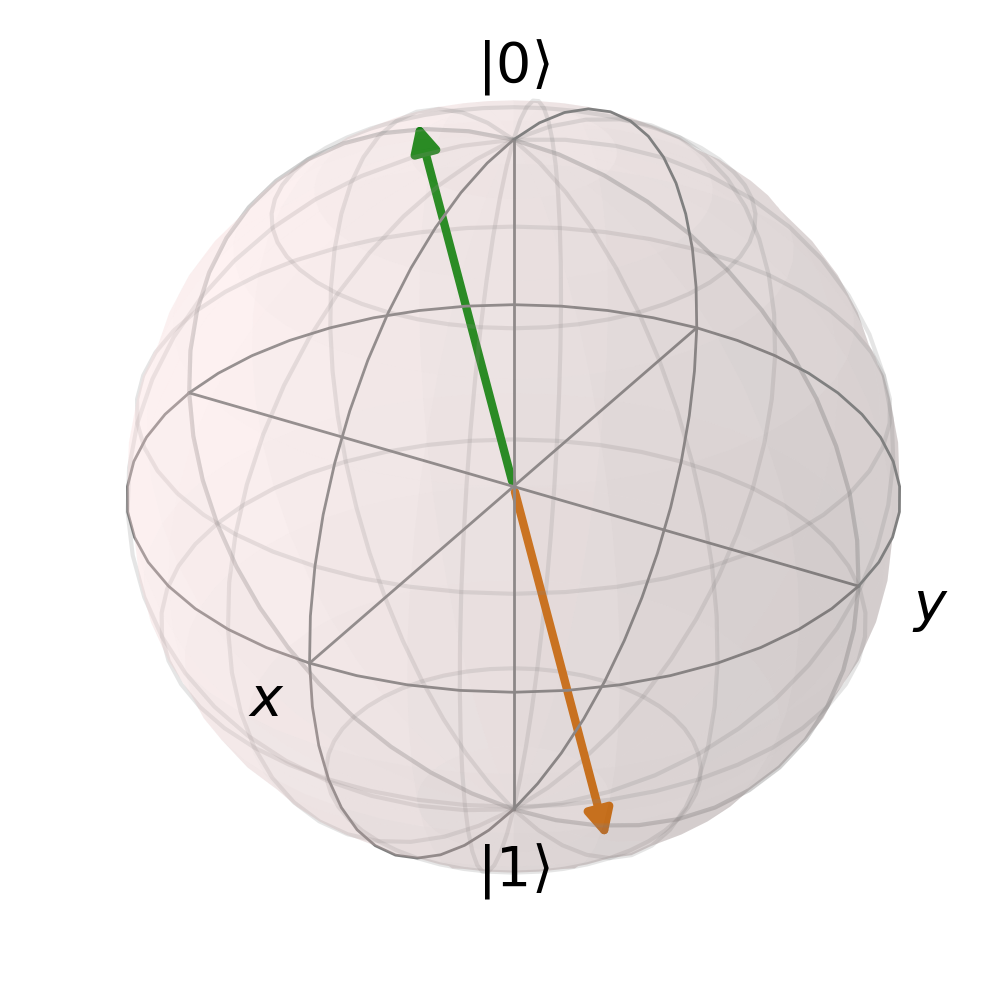

In [8]:
b = Bloch()
b.add_states(f_modes_t)
b.show()

In [9]:
# We can also precompute a table of values, much more efficient
t_list = np.linspace(0.0, T, 100)
f_modes_table_t = floquet_modes_table(f_modes_0, f_energies, t_list, H, T, args)

# And look up in it
f_modes_t = floquet_modes_t_lookup(f_modes_table_t, t, T)

<IPython.core.display.Javascript object>


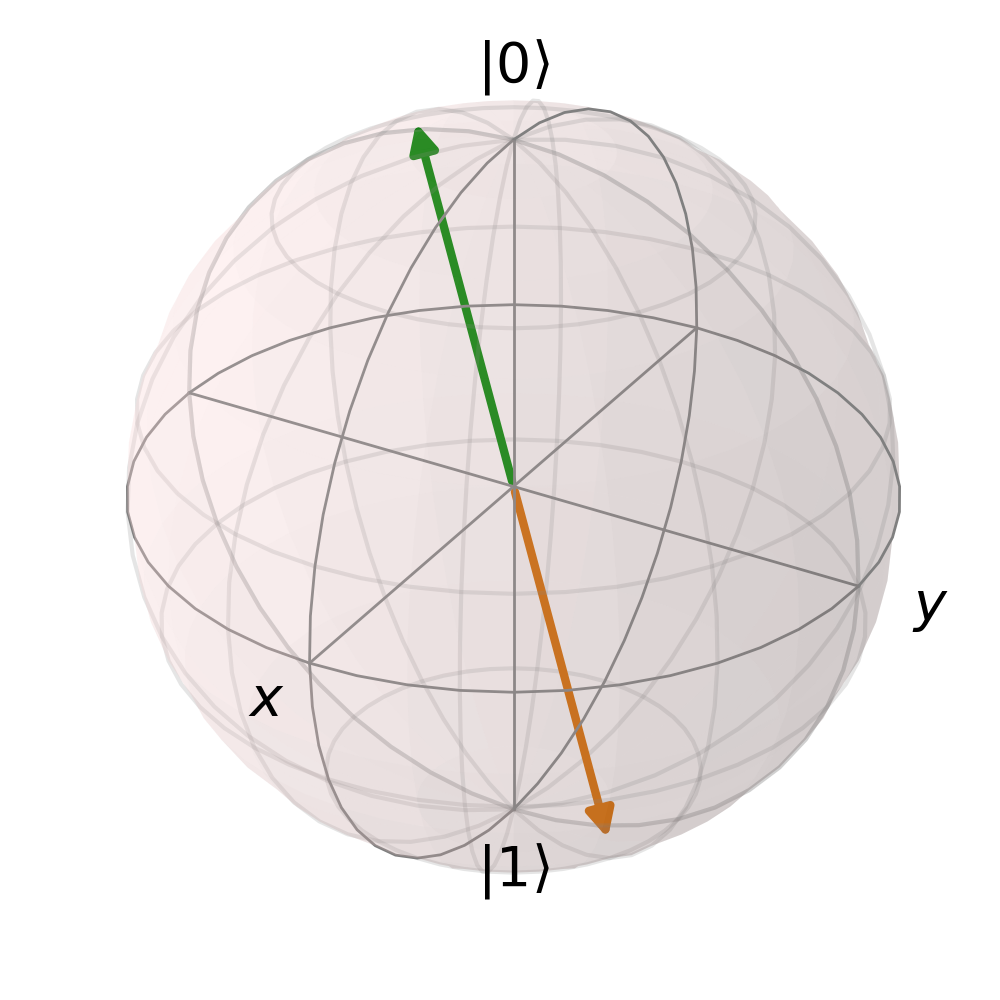

In [10]:
b = Bloch()
b.add_states(f_modes_t)
b.show()

<IPython.core.display.Javascript object>


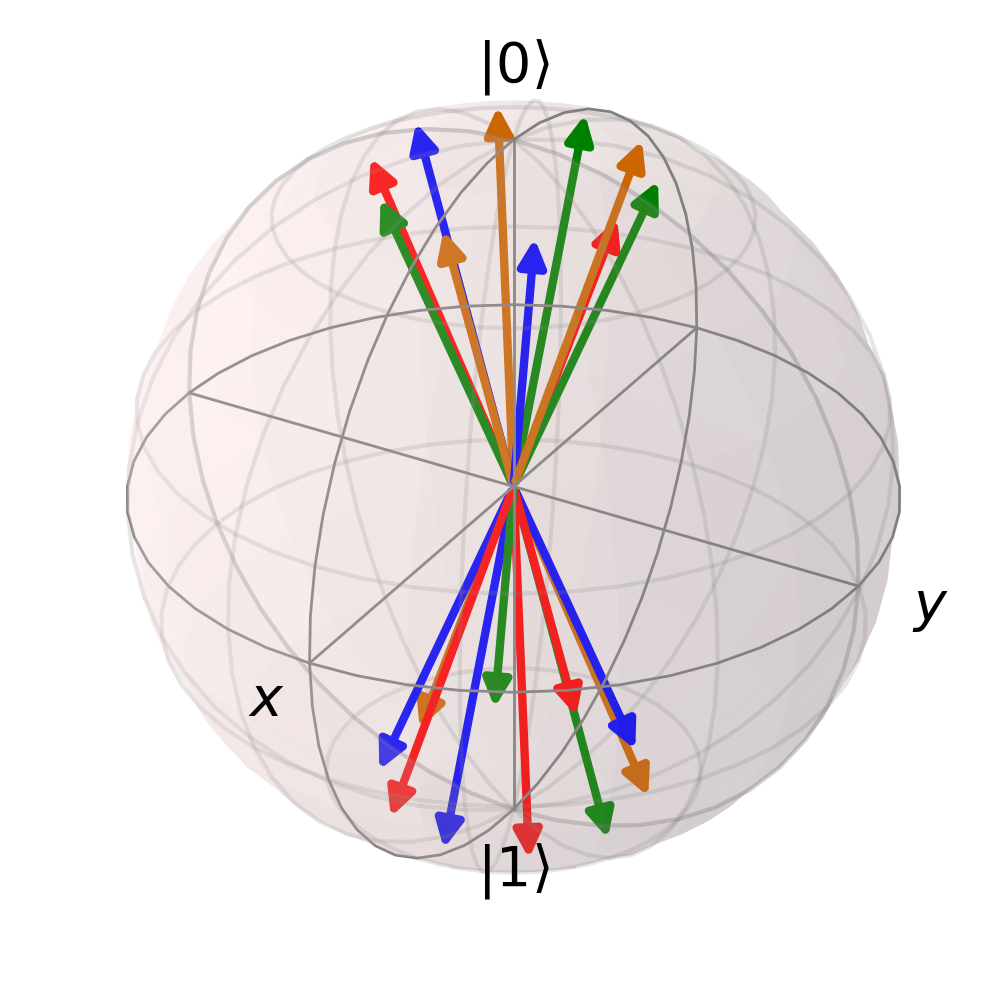

In [11]:
b = Bloch()
b.add_states([x[0] for x in f_modes_table_t[::10]])
b.add_states([x[1] for x in f_modes_table_t[::10]])
b.show()

### Decomposition on Floquet modes

<IPython.core.display.Javascript object>


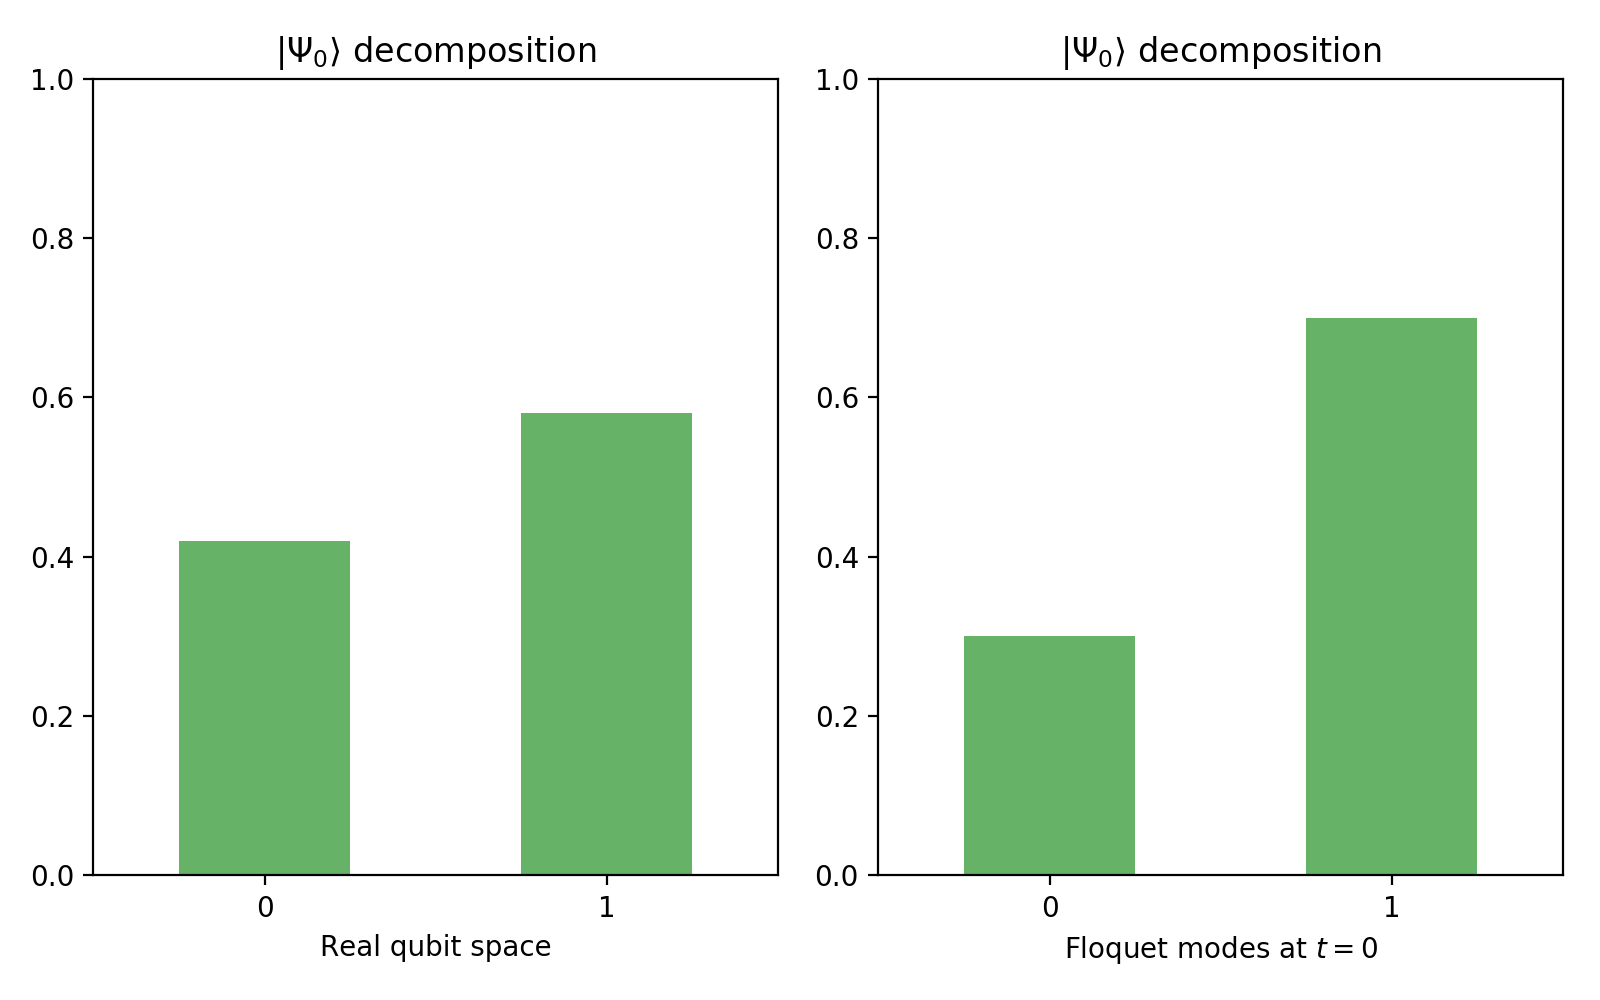

In [12]:
fig, axs = plt.subplots(1, 2)

psi_0 = rand_ket(2)
axs[0].bar(
    np.arange(0, 2),
    [np.abs(x)**2 for x in psi_0],
    color="green", alpha=0.6, width=0.5
)
axs[0].set_xticks([0, 1])
axs[0].set_xlim(-.5, len(f_modes_0) - .5)
axs[0].set_ylim(0, 1)
axs[0].set_xlabel("Real qubit space")
axs[0].set_title(r'$\left|\Psi_0\right>$ decomposition')

# Decompose the inital state in the floquet modes
f_coeff = floquet_state_decomposition(f_modes_0, f_energies, psi_0)

axs[1].bar(
    np.arange(0, len(f_coeff)),
    [np.abs(coeff)**2 for coeff in f_coeff],
    color="green", alpha=0.6, width=0.5
)
axs[1].set_xticks([0, 1])
axs[1].set_xlim(-.5, len(f_modes_0) - .5)
axs[1].set_ylim(0, 1)
axs[1].set_xlabel(r"Floquet modes at $t=0$")
axs[1].set_title(r'$\left|\Psi_0\right>$ decomposition')

fig.set_size_inches(8, 5)
fig.tight_layout()
fig.show()

### All-in-one unitary time evolution

In [13]:
e_ops = [sigmaz()]  # Observable
t_list = np.linspace(0.0, 10.0 * T, 100)

# We can just call fsesolve which handles all of this automagically
sol = fsesolve(H, psi_0, t_list, e_ops, T, args)

In [14]:
# For reference, standard Master-Equation solution is
sol_ref = mesolve(H, psi_0, t_list, [], e_ops, args)

<IPython.core.display.Javascript object>


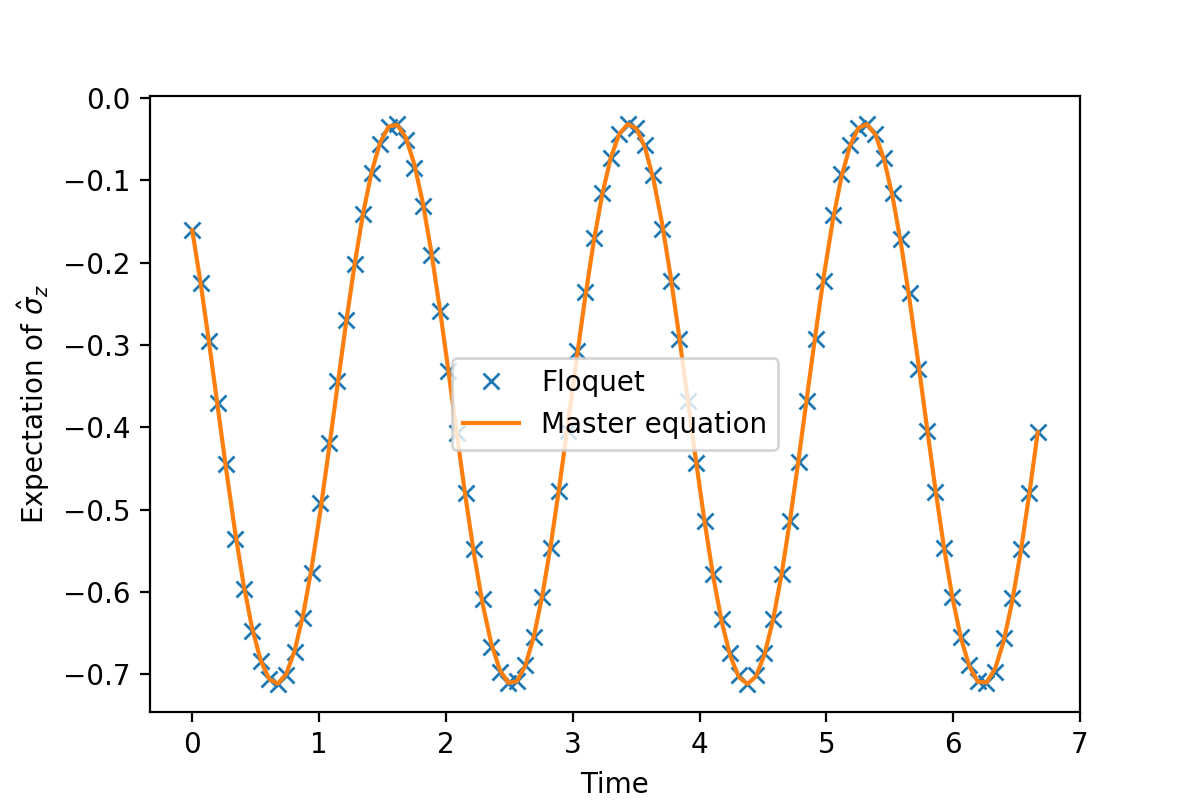

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(t_list, sol.expect[0], 'x', label="Floquet")
ax.plot(t_list, sol_ref.expect[0], label="Master equation")
ax.set_ylabel(r'Expectation of $\hat{\sigma}_z$')
ax.set_xlabel('Time')
ax.legend()
fig.show()

### Quasi-energies

In [16]:
f_energies_list = []

Omega_list = np.linspace(0.1 * (2 * np.pi), 2 * (2 * np.pi), 40)
for Omega in Omega_list:
    # Hamiltonian
    H0 = omega_0 / 2.0 * sigmaz()  # Time-independent part
    H1 = Omega * sigmax()  # Time-dependent part
    H2 = Omega * sigmay()  # Time-dependent part

    # Time-dependent hamiltonian specification
    H = [H0, [H1, 'cos(w_d * t)'], [H2, 'sin(w_d * t)']]
    args = {'w_d': omega_d}
    
    _, f_energies = floquet_modes(H, T, args)
    f_energies_list.append(f_energies)

<IPython.core.display.Javascript object>


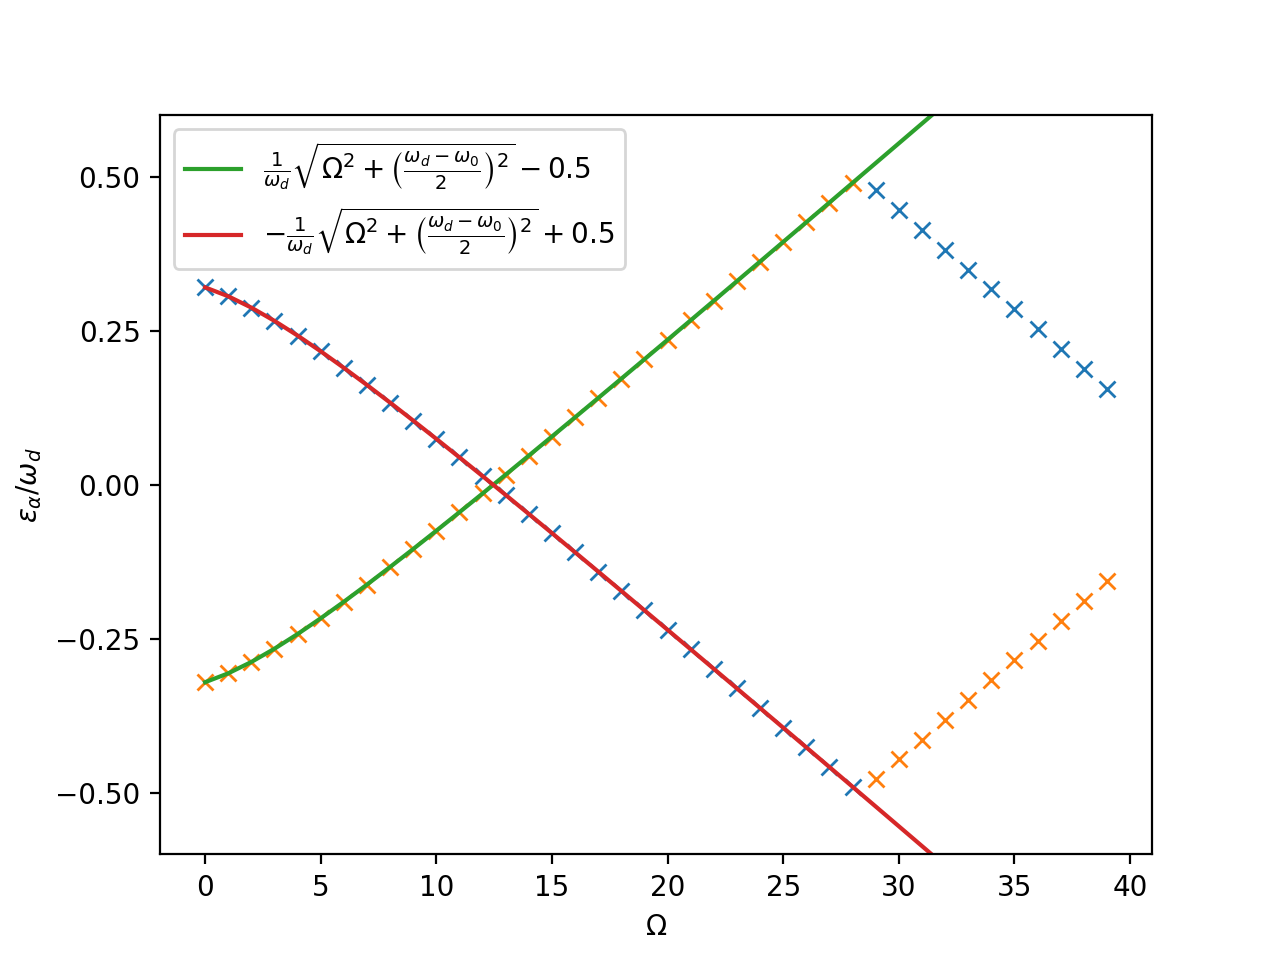

In [17]:
fig, ax = plt.subplots()
ax.plot([f_energies[0] / omega_d for f_energies in f_energies_list], 'x')
ax.plot([f_energies[1] / omega_d for f_energies in f_energies_list], 'x')
ax.plot(
    [np.sqrt(Omega**2 + (omega_d - omega_0)**2 / 4) / omega_d - 0.5 for Omega in Omega_list],
    label=r'$\frac{1}{\omega_d} \sqrt{\Omega^2 + \left(\frac{\omega_d - \omega_0}{2}\right)^2} - 0.5$'
)
ax.plot(
    [-np.sqrt(Omega**2 + (omega_d - omega_0)**2 / 4) / omega_d + 0.5 for Omega in Omega_list],
    label=r'$-\frac{1}{\omega_d} \sqrt{\Omega^2 + \left(\frac{\omega_d - \omega_0}{2}\right)^2} + 0.5$'
)
ax.set_ylim(-0.6, 0.6)
ax.set_yticks(np.arange(-0.5, 0.6, 0.25))
ax.set_ylabel(r'$\varepsilon_{\alpha} / \omega_d$')
ax.set_xlabel(r'$\Omega$')
ax.legend()
fig.show()

## Dissipative evolution

In [18]:
%matplotlib notebook

# Imports
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from floquet import *  # Temp, fix for bugs in QuTiP

In [19]:
# Parameters
wc = 1.0 * 2 * np.pi  # Cavity frequency
wp = 1.5 * 2 * np.pi  # Drive frequency
T = 2 * np.pi / wp
N = 20  # Truncature
nbar = 2
epsilon_p = np.sqrt(4 * nbar) * (wp - wc)  # Drive amplitude

# noise power spectrum
gamma1 = 0.05
def noise_spectrum(omega):
    return 0.5 * gamma1 * omega / (2 * np.pi)

In [20]:
# Define time independent hamiltonian
a = destroy(N)
H = [
    wc * a.dag() * a,
    [1.0j * epsilon_p * (a.dag() - a), 'cos(wp * t)']
]
args = {
    'wp': wp
}

In [21]:
# find the floquet modes at t=0 for the time-dependent hamiltonian
f_modes_0, f_energies = floquet_modes(H, T, args, sort=True)

# precalculate mode table at later times
t_list_f_modes = np.linspace(0, T, 500 + 1)
f_modes_table_t = floquet_modes_table(f_modes_0, f_energies,
                                      t_list_f_modes,
                                      H, T, args)

In [22]:
# Compute transition matrix between Floquet modes
_, _, _, Amat = floquet_master_equation_rates(
    f_modes_0, f_energies,
    a + a.dag(),  # Caution: We must use an hermitian operator for the dissipation description
    H, T, args, noise_spectrum,
    0,  # Temperature
    5, f_modes_table_t)

### Steadystate solution

<IPython.core.display.Javascript object>


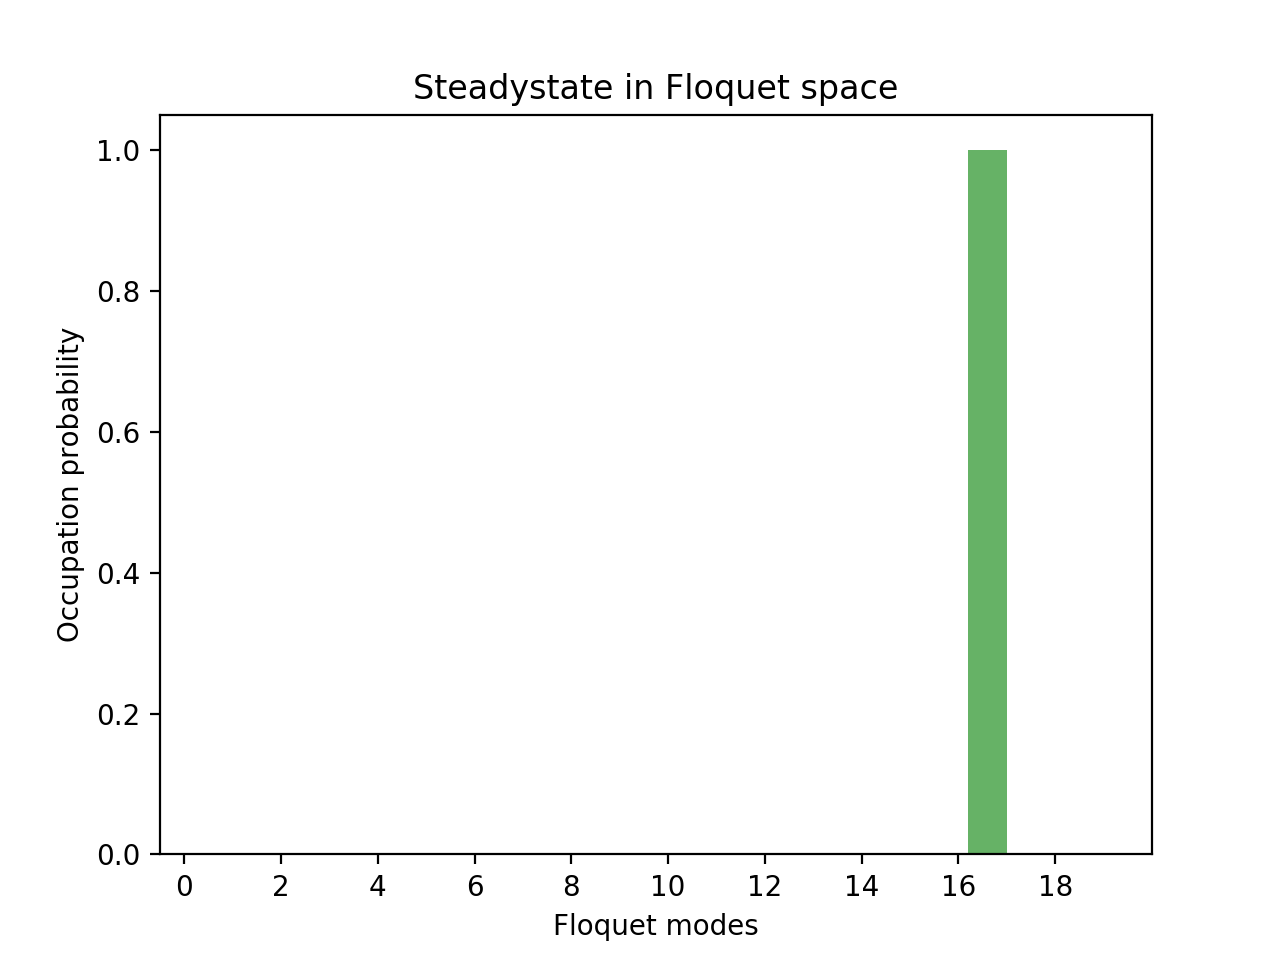

In [23]:
def floquet_master_equation_steadystate(A):
    """
    Find steadystate in Floquet domain, using RWA method from Hanggi.
    """
    B = np.zeros_like(A)
    N = A.shape[0]
    for a in range(N):
        for nu in range(N):
            if a != nu:
                B[nu, a] = A[a, nu]
            else:
                B[nu, a] = -1.0 * np.sum([
                    A[a, b] for b in range(N) if b != a]
                )
    eigv = qutip.Qobj(B).eigenstates()
    return np.real(eigv[1][-1].full())


v = floquet_master_equation_steadystate(Amat)

fig, ax = plt.subplots()
ax.bar(
    np.arange(0, len(f_modes_0)) - .4,
    (v),
    color="green", alpha=0.6, width=0.8
)
ax.set_xlim(-.5, len(f_modes_0))
ax.set_xticks(np.arange(0, N, 2.0))
ax.set_xlabel('Floquet modes')
ax.set_ylabel('Occupation probability')
ax.set_title('Steadystate in Floquet space')
fig.show()

<IPython.core.display.Javascript object>


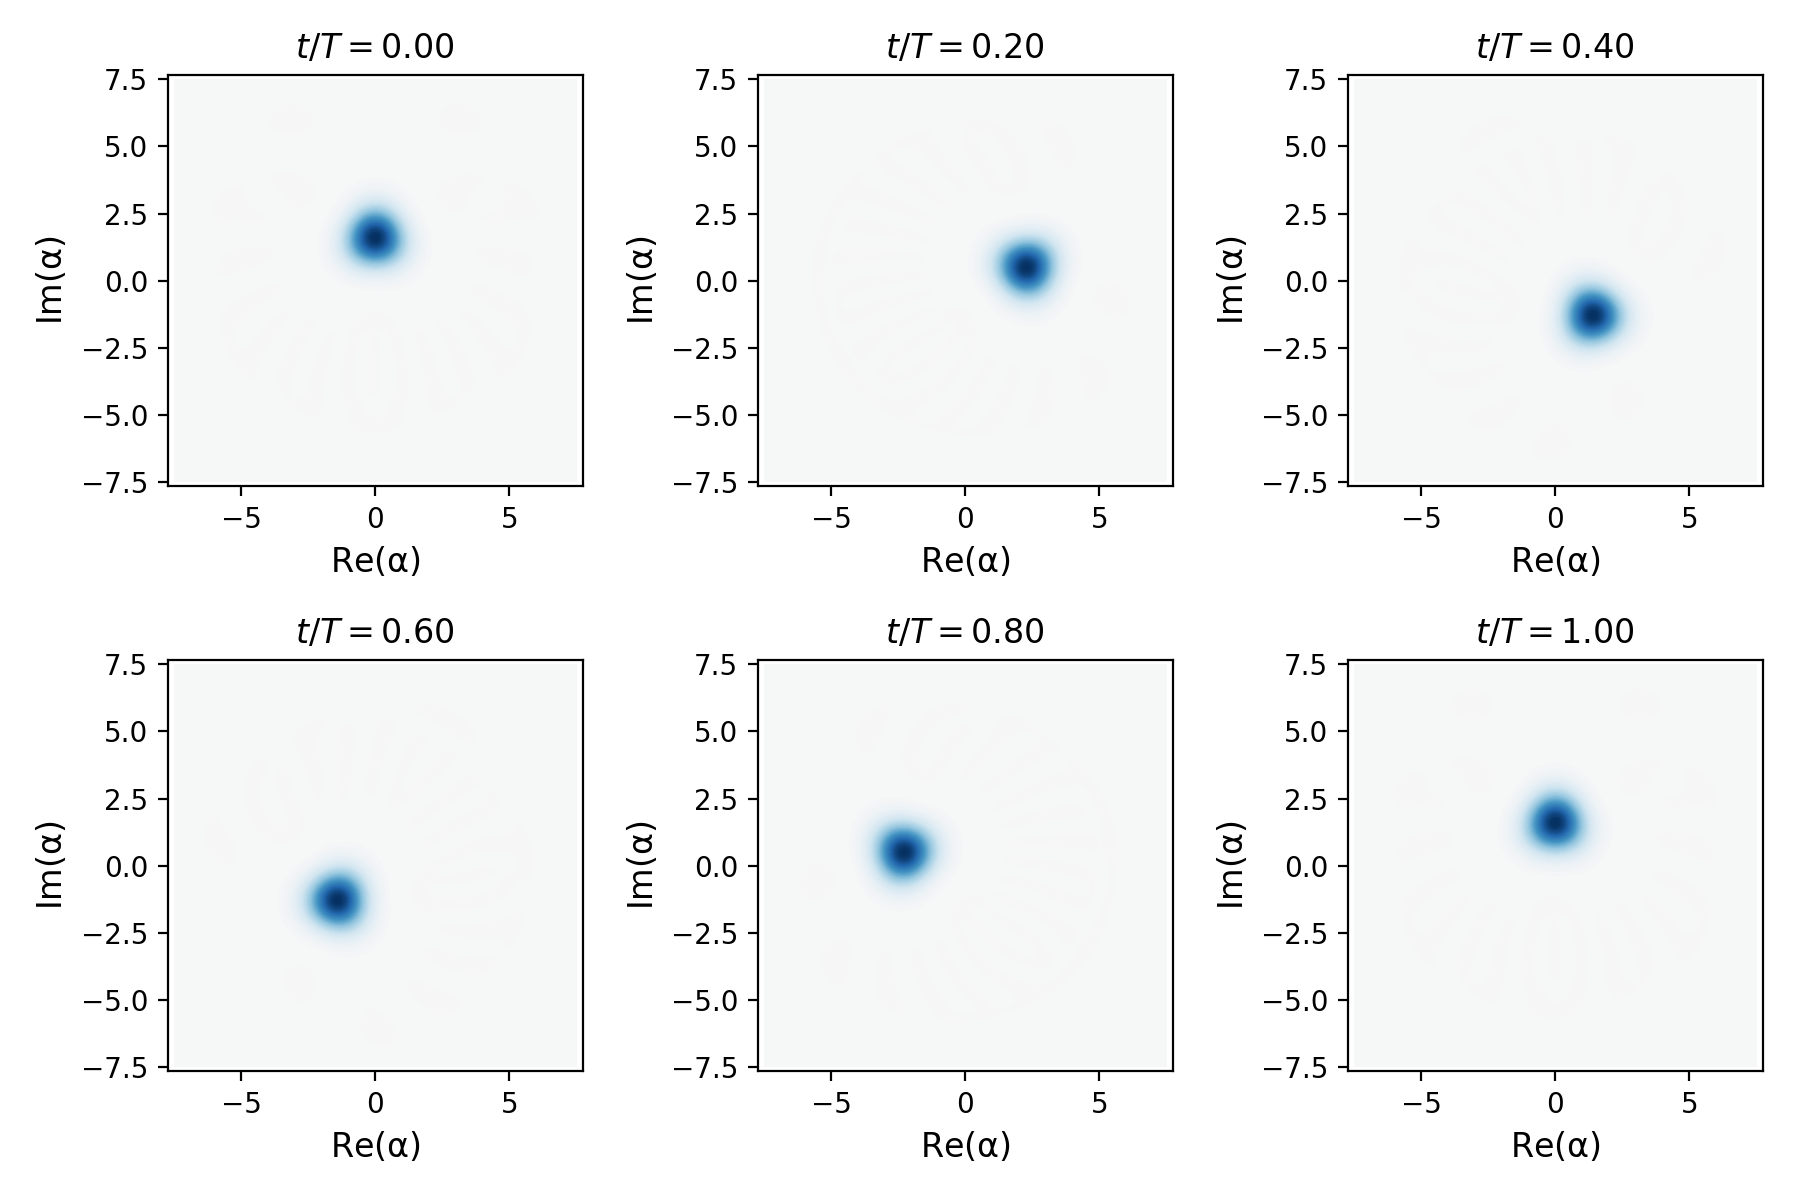

In [24]:
fig_size = (2, 3)
fig, axs = plt.subplots(*fig_size)
floquet_index = np.argmax(v)

ax_idx = 0
for i in np.linspace(0, len(t_list_f_modes) - 1, fig_size[0] * fig_size[1]):
    grid_idx = ax_idx // fig_size[1], ax_idx % fig_size[1]
    visualization.plot_wigner(f_modes_table_t[int(i)][floquet_index], fig=fig, ax=axs[grid_idx])
    axs[grid_idx].axis('equal')
    axs[grid_idx].set_title(r'$t / T=%.2f$' % (t_list_f_modes[int(i)] / T))
    ax_idx += 1

fig.set_size_inches(9, 6)
fig.tight_layout()
fig.show()